In [1]:
import IPython
print('IPython:', IPython.__version__)

import numpy as np

import scipy
print('scipy:', scipy.__version__)

import matplotlib.pyplot as plt

import sklearn
print('scikit-learn:', sklearn.__version__)

import seaborn
print('seaborn', seaborn.__version__)

import mne
print('mne', mne.__version__)

import pyedflib
print('pyedflib', pyedflib.__version__)
#to read/write EDF files = python edf library

import pandas as pd

import os

from mne.filter import filter_data

from datetime import timedelta
from scipy.signal import find_peaks_cwt

IPython: 5.3.0
scipy: 0.19.0
scikit-learn: 0.18.1
seaborn 0.7.1
mne 0.15.2
pyedflib 0.1.12


In [2]:
#define standard variables
#place a / behind participant nr and day nr
# day and mypath will serve as input for the for loops executing all functions

participant = 'Test01/'
#day = 'day1/'
#mypath = "C:/Users/Margot Heijmans/Documents/Mox Data/" + participant + day

sensorLW = '13335'
sensorRW = '13336'
sensorC = '13337'


In [2]:
#define standard variables
#place a / behind participant nr
#number of days is the number of days of which we have data
# day and mypath will serve as input for the for loops executing all functions

participant = 'Margot/'
numberofdays = 2

#color of the MOX devices set. Color is 'B', 'P' or 'O' (blue,purple,orange)
color = 'P'



if color == 'B':
    sensorLW = '13797'
    sensorRW = '13805'
    sensorC = '13804'
    
if color == 'P':
    sensorLW = '13799'
    sensorRW = '13801'
    sensorC = '13792'
    
if color == 'O':
    sensorLW = '13794'
    sensorRW = '13793'
    sensorC = '13803'  

In [14]:
def selectfiles(participant,day,mypath,sensorLW,sensorRW,sensorC):
    # adapted so now you can have more files a day

    from os import listdir
    #method listdir() returns a list containing the names of the entries in the directory given by path.

    from os.path import isfile, join
    #returns true if file in path is an existing regular file

    #bdffiles = [f for f in listdir(mypath) if isfile(join(mypath,f)) and f[0]!='_' and f[-3:] =='bdf']
    
    bdffiles = [f for f in listdir(mypath) if isfile(join(mypath,f)) and f[0]!='_' and f[-3:] =='edf']
    #bdffiles are the files in mypath, not directories. 
    #if they are existing regular files 
    #if first element is not ?
    #if it is a .bdf file

    dataFrame = pd.DataFrame()
    #creates a 2D tabular data structure with labeled axes
    #parameters: data, index, columns, dtype, copy

    leftWristFileName = ([f for f in bdffiles if f[:5]== sensorLW])
    if len(leftWristFileName) > 1:
        a = list(range(0,len(leftWristFileName)))
        leftWristFile = []
        for i in a:
            leftWristFile.append("C:/Users/Margot Heijmans/Documents/Mox Data/" + participant + day + leftWristFileName[i])
    else:
        leftWristFile = "C:/Users/Margot Heijmans/Documents/Mox Data/" + participant + day + " ".join(leftWristFileName)


    rightWristFileName = ([f for f in bdffiles if f[:5] == sensorRW])
    if len(rightWristFileName) > 1:
        a = list(range(0,len(rightWristFileName)))
        rightWristFile = []
        for i in a:
            rightWristFile.append("C:/Users/Margot Heijmans/Documents/Mox Data/" + participant + day + rightWristFileName[i])
    else:
        rightWristFile = "C:/Users/Margot Heijmans/Documents/Mox Data/" + participant + day + " ".join(rightWristFileName)


    chestFileName = ([ f for f in bdffiles if f[:5] == sensorC])
    if len(chestFileName) > 1:
        a = list(range(0,len(chestFileName)))
        chestFile = []
        for i in a:
            chestFile.append("C:/Users/Margot Heijmans/Documents/Mox Data/" + participant + day + chestFileName[i])
    else:
        chestFile = "C:/Users/Margot Heijmans/Documents/Mox Data/" + participant + day + " ".join(chestFileName)
    
    return leftWristFile,leftWristFileName, rightWristFile, rightWristFileName, chestFile, chestFileName

In [15]:
def readData(filename):
    #Extract data
    
    f = pyedflib.EdfReader(filename) 
    #reading in edf file
    
    sr = f.getSampleFrequencies()[0] 
    #get sample freq out of edf file via edflib
   
    n = f.signals_in_file 
    #defining number of channels
    
    signal_labels = f.getSignalLabels() 
    #defining channel labels
    
    sigbufs = np.zeros((n, f.getNSamples()[0])) 
    #create a matrix with all zeros. size of channels X number of samples
    #to get the size --> print(sigbufs.shape) 
    
    #np.arange returns evenly spaced values within a given interval
    #PYTHON STARTS COUNTING AT 0!
    
    for i in np.arange(n): 
        sigbufs[i, :] = f.readSignal(i) 
        #reading in data of each row and put this into collumns in f
        
    #when a line is not moved to the right anymore, the loop has ended
    
    startingTime=filename[-19:-4] 
    #extract starting time from file name by specifying its index
    
    startingTime=pd.to_datetime(startingTime, format='%Y%m%d_%H%M%S', errors='ignore') 
    #pd.to_datetime = function from pandas to convert string into date time
    
    timeStamps=[] 
    #empty list here we are creating time of all measurements
   
    last=startingTime 
    
    for time in range(f.getNSamples()[0]): 
        #range from 0 till number of samples
        timeStamps.append(last)
        #startingTime is added as first value into timeStamp list
        last=last+pd.Timedelta('%d ms' %(1000/sr)) 
        #now the time of one sample is added to the starting time to create list
        #timeStamps consist of date (Y,M,D) and time (H,M,S,MS)
        
    f._close()
    #the method close() closes the file. the file cannot be read or written anymore
    
    return signal_labels, timeStamps, sigbufs, sr

In [29]:
def extractData(leftWristFile,rightWristFile,chestFile):
    
    # leftWristData
    
    if len(leftWristFileName) > 1:
        a = list(range(0,len(leftWristFile)))
        data=[]
        timeStamps=[]
        for i in a:
            labels, timeStampsi, datai, sr = readData(leftWristFile) 
            timeStamps += timeStampsi
            if i == 0:
                data = datai 
            else:
                data = np.concatenate((data,datai),axis=1)        
    else:
        labels, timeStamps, data, sr = readData(leftWristFile) 
    
    labels = labels+['AccSum']+['GyrSum']
    labels=[l + 'L' for l in labels] #adds L(left) to 'labels':collumn-names of readData

    accsquared = data[0]**2 + data[1]**2 + data[2]**2
    gyrsquared = data[3]**2 + data[4]**2 + data[5]**2

    accSum = np.sqrt(accsquared)
    gyrSum = np.sqrt(gyrsquared)

    datatot = np.c_[data.T,accSum,gyrSum]
    
       
    leftWristDF=pd.DataFrame(datatot,columns=labels,index=timeStamps)
   
    # creates pandasDataFrame for leftWrist and fills it with leftWristFeatures(transposed), names collumns with 
    # labels+L and sets alignedTimes (still timeStamps+featureWindowLength) as index.
    
    ### Same for right wrist ###
    
    if len(rightWristFileName) > 1:
        a = list(range(0,len(rightWristFile)))
        data =[]
        timeStamps=[]
        for i in a:
            labels,timeStampsi,datai,sr = readData(rightWristFile[i])
            timeStamps += timeStampsi
            if i == 0:
                data = datai 
            else:
                data = np.concatenate((data,datai),axis=1)    
    else:
        labels, timeStamps, data, sr = readData(rightWristFile)
     
    labels = labels+['AccSum']+['GyrSum']
    labels=[l + 'R' for l in labels]
    
    accsquared = data[0]**2 + data[1]**2 + data[2]**2
    gyrsquared = data[3]**2 + data[4]**2 + data[5]**2

    accSum = np.sqrt(accsquared)
    gyrSum = np.sqrt(gyrsquared)

    datatot = np.c_[data.T,accSum,gyrSum]
   
    rightWristDF=pd.DataFrame(datatot,columns=labels,index=timeStamps)
    
    ### Same for chest ###
    
    if len(chestFileName) > 1:
        a = list(range(0,len(chestFile)))
        data=[]
        timeStamps=[]
        for i in a:
            labels, timeStampsi, datai, sr = readData(chestFile) 
            timeStamps += timeStampsi
            if i == 0:
                data = datai
            else:
                data = np.concatenate((data,datai),axis=1)     
    else:
        labels, timeStamps, data, sr = readData(chestFile) 
    
    #make chest specific features?
    labels = labels+['AccSum']+['GyrSum']
    labels=[l + 'C' for l in labels]
   
    accsquared = data[0]**2 + data[1]**2 + data[2]**2
    gyrsquared = data[3]**2 + data[4]**2 + data[5]**2

    accSum = np.sqrt(accsquared)
    gyrSum = np.sqrt(gyrsquared)

    datatot = np.c_[data.T,accSum,gyrSum]
  
    chestDF=pd.DataFrame(datatot,columns=labels,index=timeStamps)
    
    return leftWristDF,rightWristDF,chestDF,sr   
## keeps sensors in separate dataframes, to simplify the allignment with ESMdata (possible different first timeStamps
## in different sensors. timeStamps of ESM will be used)

In [30]:
def plotData(mypath,leftWristDF,rightWristDF,chestDF):

#plot the raw data and save in participant folder, even if file already exists

    script_dir = os.path.dirname(mypath)
    results_dir = os.path.join(script_dir, 'Plots/')
    
    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)

    sample_file_name = "rawL.png"
    if not os.path.isfile(results_dir+sample_file_name):
        plt.figure(1)
        plt.subplot(211)
        plt.ylabel('acceleration')
        plt.plot(leftWristDF['AccXL'],'r-',leftWristDF['AccYL'], 'b-',leftWristDF['AccZL'], 'g-' ,linewidth= 0.5)

        plt.subplot(212)
        plt.plot(leftWristDF['GyroXL'],'r-',leftWristDF['GyroYL'], 'b-', leftWristDF['GyroZL'], 'g-',linewidth=0.3)
        plt.ylabel('gyroscope')
        plt.savefig(results_dir + sample_file_name)
        plt.show()
    else:
        print('plot rawL already saved')
    
    sample_file_name = "rawR.png"
    if not os.path.isfile(results_dir+sample_file_name):
        plt.figure(2)
        plt.subplot(211)
        plt.ylabel('acceleration')
        plt.plot(rightWristDF['AccXR'],'r-',rightWristDF['AccYR'], 'b-',rightWristDF['AccZR'], 'g-' ,linewidth= 0.5)

        plt.subplot(212)
        plt.plot(rightWristDF['GyroXR'],'r-',rightWristDF['GyroYR'], 'b-', rightWristDF['GyroZR'], 'g-',linewidth=0.3)
        plt.ylabel('gyroscope')
        plt.savefig(results_dir + sample_file_name)
        plt.show()
    else:
        print('plot rawR already saved')
        
    sample_file_name = "rawC.png"
    if not os.path.isfile(results_dir+sample_file_name):
        plt.figure(3)
        plt.subplot(211)
        plt.ylabel('acceleration')
        plt.plot(chestDF['AccXC'],'r-',chestDF['AccYC'], 'b-',chestDF['AccZC'], 'g-' ,linewidth= 0.5)

        plt.subplot(212)
        plt.plot(chestDF['GyroXC'],'r-',chestDF['GyroYC'], 'b-', chestDF['GyroZC'], 'g-',linewidth=0.3)
        plt.ylabel('gyroscope')
        plt.savefig(results_dir + sample_file_name)
        plt.show()
    else:
        print('plot rawC already saved')

In [22]:
def saveData(mypath,leftWristDF,rightWristDF,chestDF):
#save raw data files in participant folder
#not if files already exist in that folder

    script_dir = os.path.dirname(mypath)
    results_dir = os.path.join(script_dir, 'RawData/')
    results_dir
    
    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)

    
    sample_file_name = "rawL.csv"
    if not os.path.isfile(results_dir+sample_file_name):
        leftWristDF.to_csv(results_dir + sample_file_name)
    else:
        print('file rawL already saved')
    
    
    sample_file_name = "rawR.csv"
    if not os.path.isfile(results_dir+sample_file_name):
        rightWristDF.to_csv(results_dir + sample_file_name)
    else:
        print('file rawR already saved')
    
    
    sample_file_name = "rawC.csv"
    if not os.path.isfile(results_dir+sample_file_name):
        chestDF.to_csv(results_dir + sample_file_name)
    else:
        print('file rawC already saved')

In [90]:
numberofdays = 2
#dataLength = np.zeros([numberofdays,1])

for i in range(1,numberofdays+1):
    day = ('day'+str(i)+'/')
    mypath = "C:/Users/Margot Heijmans/Documents/Mox Data/" + participant + day
    print('analysing ' + participant + day)
    leftWristFile,leftWristFileName,rightWristFile,rightWristFileName,chestFile,chestFileName = selectfiles(participant,day,mypath,sensorLW,sensorRW,sensorC)
    leftWristDF,rightWristDF,chestDF,sr = extractData(leftWristFile,rightWristFile,chestFile)
    plotData(mypath,leftWristDF,rightWristDF,chestDF)
    saveData(mypath,leftWristDF,rightWristDF,chestDF) 
    

IndexError: list assignment index out of range

In [ ]:
    chestTimes = chestDF.index
    measurementTime = chestTimes[-1:]-chestTimes[0]
    dataLength[i] = day

In [34]:
chestDF

,AccXC,AccYC,AccZC,GyroXC,GyroYC,GyroZC,AccSumC,GyrSumC
2018-06-05 06:27:32.000,-0.062014,-0.043458,-0.945585,-0.910014,1.890028,2.310035,0.948613,3.120351
2018-06-05 06:27:32.005,-0.053224,-0.038575,-0.936796,-0.630009,1.750026,2.100032,0.939100,2.805287
2018-06-05 06:27:32.010,-0.062502,-0.034181,-0.933134,-1.260019,1.960029,2.380036,0.935849,3.330756
2018-06-05 06:27:32.015,-0.050050,-0.046388,-0.949004,-0.770012,1.960029,2.240034,0.951454,3.074473
2018-06-05 06:27:32.020,-0.065188,-0.014161,-0.963652,-1.470022,2.100032,2.100032,0.965959,3.313794
2018-06-05 06:27:32.025,-0.066897,-0.059572,-0.976104,-0.350005,1.960029,2.170033,0.980206,2.945040
2018-06-05 06:27:32.030,-0.069094,-0.027100,-0.952177,-1.120017,1.610024,2.170033,0.955066,2.925005
2018-06-05 06:27:32.035,-0.066652,-0.054933,-0.971221,-0.910014,1.890028,2.310035,0.975054,3.120351
2018-06-05 06:27:32.040,-0.073000,-0.035890,-0.970000,-1.120017,2.030030,2.310035,0.973405,3.272877
2018-06-05 06:27:32.045,-0.073000,-0.025880,-0.938505,-0.770012,1.820027,2.170033,0.941696,2.935040


In [46]:
numberofdays = 2
dataLength = []

for i in range(1,numberofdays+1):
    day = ('day'+str(i)+'/')
    mypath = "C:/Users/Margot Heijmans/Documents/Mox Data/" + participant + day

chestTimes = chestDF.index
chestTimes[-1:]-chestTimes[0]



TimedeltaIndex(['15:55:31.995000'], dtype='timedelta64[ns]', freq=None)

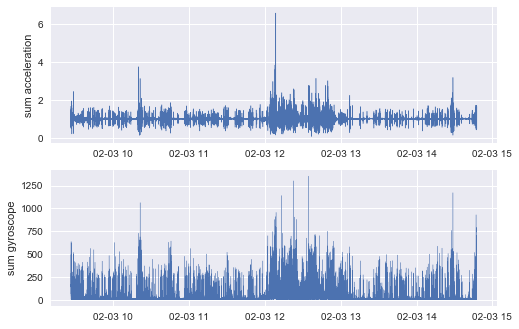

In [98]:
plt.figure(1)
plt.subplot(211)
plt.ylabel('sum acceleration')
plt.plot(leftWristDF['AccSumL'] ,linewidth= 0.5)

plt.subplot(212)
plt.plot(leftWristDF['GyrSumL'],linewidth=0.3)
plt.ylabel('sum gyroscope')
plt.show()

In [27]:
chestsum = pd.DataFrame(chestGyrSum,chestAccSum)

In [38]:
chestsum = {'gyrsum': chestGyrSum.T, 'accsum': chestAccSum.T}


In [40]:
chestDF = chestDF.append(chestsum, ignore_index=True)

In [39]:
chestDF.index


DatetimeIndex([       '2018-06-05 06:27:32', '2018-06-05 06:27:32.005000',
               '2018-06-05 06:27:32.010000', '2018-06-05 06:27:32.015000',
               '2018-06-05 06:27:32.020000', '2018-06-05 06:27:32.025000',
               '2018-06-05 06:27:32.030000', '2018-06-05 06:27:32.035000',
               '2018-06-05 06:27:32.040000', '2018-06-05 06:27:32.045000',
               ...
               '2018-06-05 22:23:03.950000', '2018-06-05 22:23:03.955000',
               '2018-06-05 22:23:03.960000', '2018-06-05 22:23:03.965000',
               '2018-06-05 22:23:03.970000', '2018-06-05 22:23:03.975000',
               '2018-06-05 22:23:03.980000', '2018-06-05 22:23:03.985000',
               '2018-06-05 22:23:03.990000', '2018-06-05 22:23:03.995000'],
              dtype='datetime64[ns]', length=11466400, freq=None)

In [ ]:

#Filter data between 4 and 8 Hz
filtData = filter_data(data, sr, 4,8) #filter_data = function of nme

#Extract some sort of feature for all windows and corresponding time stamps
numSamples=data.shape[1]
    
# Getting number and names of features
# giving '_' to store in means, do not store this variable; here only interested in tremorNames, not in features
tremorNames, _ = tremorFeatures(data[:,:windowLength*sr], sr) 
bradyNames, _ = bradykinesiaFeatures(data[:,:windowLength*sr], sr)
    
features=np.zeros((len(tremorNames) + len(bradyNames),int(numSamples/(windowLength*sr)))) 
# create empty matrix again, MNE-package stores data in row-form, so number of rows is number of features
# this gets transposed in extractAllSensors function
alignedTimes=[] #empty list
for i,win in enumerate(range(0,numSamples,windowLength*sr)): 
#range: gives list with starting points of windows, range(start, end (not considered),stepwidth)
#enumerate: x=1,2,3,etc; y=sample numbers which are beginnings of windows
#Average power per channel; mean of squared; later: try sq root/ logarithmic scale??
        
    startOfWin=win
    endOfWin=win+windowLength*sr    
    if i<features.shape[1]:
            #features[:,i]=np.mean(filtData[:,startOfWin:endOfWin]**2,axis=1) #old calculation of means
            #fill designated collumns of empty array 'features', with tremorFeatures and bradykinesiaFeatures
        _,features[:len(tremorNames),i] = tremorFeatures(data[:,startOfWin:endOfWin],sr)
           # _,features[len(tremorNames):,i] = bradykinesiaFeatures(data[:,startOfWin:endOfWin],sr)
        _,features[len(tremorNames):,i] = bradykinesiaFeatures(data[:,startOfWin:endOfWin],sr)
            # here only interested in features, not in tremor/bradyNames, so for first output '_'
            
            #Timestamp at beginning of each window
        alignedTimes.append(timeStamps[win])
return alignedTimes, features, tremorNames + bradyNames

In [ ]:
filtData = filter_data(data, sr, 4,8) #filter_data = function of nme